In [1]:
%load_ext line_profiler

In [2]:
import jax.numpy as np
import matplotlib.pyplot as plt
from numpy.random import seed as set_seed, randint
from scipy import stats
from jax.interpreters.xla import DeviceArray
from jax import grad, jit
import jax
import pandas as pd
from numpy import ravel_multi_index as numpy_ravel_multi_index

plt.style.use('seaborn-darkgrid')
plt.rcParams['image.cmap'] = 'Dark2'
plt.rcParams['figure.figsize'] = [9.0, 6.0]
plt.rcParams['font.size'] = 14
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Definitions

In [3]:
def classify_with_hyperplane(X, w) -> '(X.shape[0],)':
    return np.sign(X @ w)


def plot_2d_problem(X, y=None, B=None, RX=None):
    x = np.linspace(X.min(), X.max(), 100)
    plt.scatter(*X.T, c=y, alpha=0.25)
    plt.plot(x, x, 'k--', alpha=0.15)
    if B is not None:
        for b, i in zip(*B):
            if i == 0:
                plt.vlines(b, X[:, 1].min(), X[:, 1].max(),
                           colors='k', linestyles='dashed', size=1)
            elif i == 1:
                plt.hlines(b, X[:, 0].min(), X[:, 0].max(),
                           colors='k', linestyles='dashed', size=1)
        
    if RX is not None:
        plt.scatter(*RX.T, s=100, marker='X', c='black')

    
def sigmoid(x) -> 'x.shape':
    return 1/(1 + np.exp(-x))


def make_normal_unit_vector(d) -> '(d,)':
    v = np.append(-1, np.ones(d-1))
    return v/np.sqrt(v@v)


def add_seperation(X, sep=0) -> 'X: (N, d); y: (N,)':
    d = X.shape[1]
    w = make_normal_unit_vector(d)
    y = np.sign(X @ w)
    X += sep*y[:, np.newaxis]*w
    return X, y


def generate_random_reconstruction_points(X, M, d) -> '(M, d)':
    dist = stats.uniform(loc=X.min(), scale=X.max() - X.min())
    return np.array(dist.rvs(size=(M, d)))


def calc_best_rpoints(X, Qinv, RX=None) -> '(M, d)':
    if RX is not None:
        X = np.concatenate((X, RX), axis=0)
        Qinv = np.concatenate((Qinv, np.arange(RX.shape[0])))
    return np.array([X[Qinv == i].mean(axis=0) for i in range(M)])


def calc_optimal_reconstruction_points(Q, X, y, aux, γ) -> '(M, d)':
    flattener = aux['flattener']
    aux1 = aux['aux1']
    w = aux['w']
    Q_flat = ((Q @ flattener)[:, np.newaxis] + aux1).ravel('F')
    p = classify_with_hyperplane(X, w)
    K = np.array([-1, 1])
    X = X + γ/2*y[:, np.newaxis]*w[np.newaxis]*(p[:, np.newaxis] != y[:, np.newaxis])
    avgs = np.bincount(Q_flat, weights=X.ravel('F'))/np.bincount(Q_flat)
    avgs = avgs[~np.isnan(avgs)]
    d = X.shape[1]
    M = int(np.unique(avgs).shape[0]/d)
    return avgs.reshape((M, -1), order='F')


def calc_distortion(X, RXs, d_axis=-1):
    return ((X - RXs)**2).sum(axis=d_axis)


def calc_01_loss(X, RXs, w):
    return (classify_with_hyperplane(X, w) 
            != classify_with_hyperplane(RXs, w))


def calc_boundary_distance_distortion(X, RXs, w):
    y = classify_with_hyperplane(X, w)
    yr = classify_with_hyperplane(RXs, w)
    return (y - yr)/2*((X - RXs) @ w)


def calc_loss(X, RX, Q, aux, γ, d_axis=-1):
    flattener = aux['flattener']
    w = aux['w']
    RXs = RX[Q @ flattener]
    distortion = calc_distortion(X, RXs, d_axis)
#     zero_one_loss = calc_01_loss(X, RXs, w)
    classification_loss = calc_boundary_distance_distortion(X, RXs, w)
    return ((1 - γ)*distortion + γ*classification_loss,
            distortion,
            classification_loss)


def calc_nondistributed_q_indices(X, RX, R):
    N, d = X.shape
    Q_flat = ((X[:, np.newaxis] - RX)**2).sum(axis=-1).argmin(axis=-1)
    return np.stack(np.unravel_index(Q_flat, d*[2**R]))[::-1].T


def calc_optimal_quantization_indices_parallel(RX, X, Q, R, aux, γ):
    N = Q.shape[0]
    loss = calc_loss(Xs[:, np.newaxis], RX, Qs, aux, γ).mean(axis=-1)
    return loss.argmin(axis=1)


def freeze_Q(Q, i, R) -> '(2**R, ...)':
    N, d = Q.shape
    assert i < d
    Q_repeated = Q[np.newaxis].repeat(2**R, axis=0)
    K = np.arange(2**R)[:, np.newaxis].repeat(N, axis=1)
    return Q_repeated.at[:, :, i].set(K)


def calc_optimal_quantization_indices_sequential(RX, X, Q, R, aux, γ):
    d = Q.shape[1]
    for i in range(d):
        Qi = freeze_Q(Q, i, R)
        loss, _, _ = calc_loss(X, RX, Qi, aux, γ)
        Qi_new = np.nanargmin(loss, axis=0)
        Q = Q.at[:, i].set(Qi_new)
    return Q


def count_boundaries(X, Q, RX, w):
    N, d = X.shape
    i_sorted = X.argsort(axis=0)
    K = np.arange(0, d)[np.newaxis].repeat(N, axis=0)
    return np.abs(np.diff(Q[i_sorted, K], axis=0)).sum().item()


def make_boundaries(X, Q):
    assert X.shape[1] == 2, 'Only implemented for d == 2'
    i_sorted = X.argsort(axis=0)
    K = np.array([0, 1])[np.newaxis].repeat(X.shape[0], axis=0)
    boundary_indices = np.nonzero(np.diff(Q[i_sorted, K], axis=0))
    return np.array(X[i_sorted, K][boundary_indices]), boundary_indices[1]

/home/dsevero/miniconda3/envs/dsevero.com/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


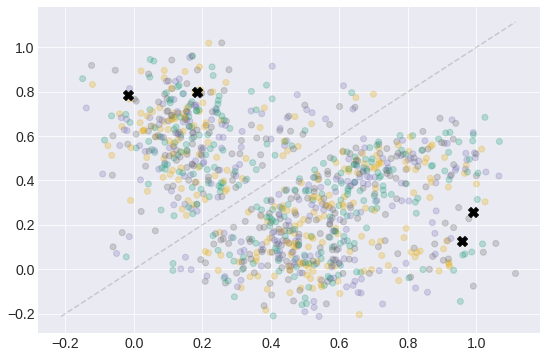

In [4]:
seed: 'global numpy seed' = 2
set_seed(seed)

N: 'sample size' = 1_000
d: 'problem dimension' = 2
R: 'bit rate per dimension' = 1
X: 'sample' = (stats
               .multivariate_normal(mean=stats.uniform().rvs(20*d),
                                    cov=1e-2)
               .rvs(size=int(N/20))
               .reshape(-1, d))
# X = stats.uniform().rvs((N, d))

X, y = add_seperation(X, 0.05)
M: 'number of reconstruction points' = 2**(R*d)
RX: 'reconstruction points' = generate_random_reconstruction_points(X, M, d)
Q: 'quantization indices' = np.array(stats.randint(0, 2**R).rvs((N, d)))
# Q  = calc_nondistributed_q_indices(X, RX)
flattener: 'vector that flattens the quantion indices with Q @ flattener' = np.array([2**(R*i) for i in range(d)])
w = make_normal_unit_vector(d)
aux1 = np.array([i*M for i in range(d)])[np.newaxis]
aux = {'flattener': flattener,
       'aux1': aux1,
       'w': w}

assert Q.shape == (N, d)

# RX = calc_optimal_reconstruction_points(Q, X, aux)
if d == 2:
    plot_2d_problem(X, Q @ flattener, RX=RX)
    plt.show()

# Optimal Distributed Quantizer Design (no side-information)

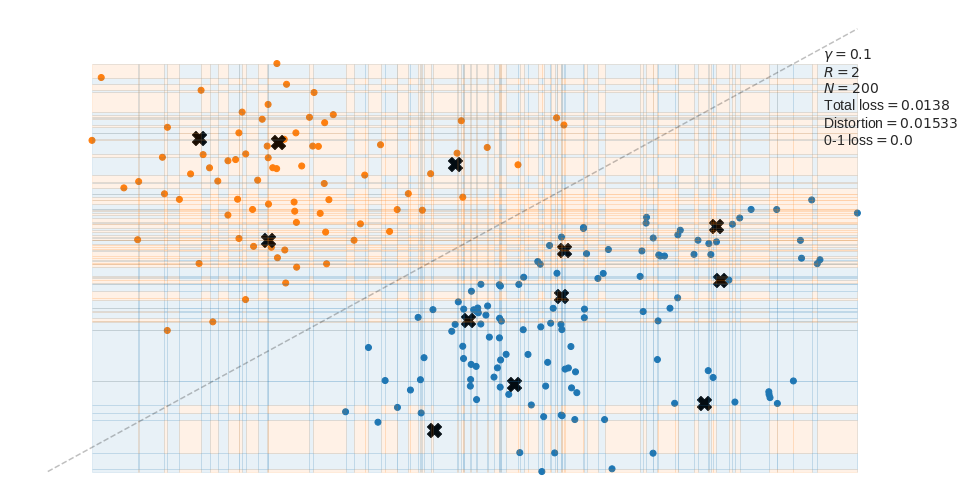

In [17]:
from joblib import Memory
from functools import lru_cache
from toolz import concat

memory = Memory('cache')

@lru_cache()
# @memory.cache
def run_single(d, R, N, sep=0, q_method='sequential',
               seed=0, iters=10, γ=0, return_arrays=False):
    set_seed(seed)
    X = (stats
         .multivariate_normal(mean=stats.uniform().rvs(20*d),
                              cov=1e-2)
         .rvs(size=int(N/20))
         .reshape(-1, d))
#     X = stats.uniform().rvs((N, d))
    X = np.array(X)
    X, y = add_seperation(X, sep)
    M = 2**(R*d)
    RX = generate_random_reconstruction_points(X, M, d)

    Q  = calc_nondistributed_q_indices(X, RX, R)
    flattener = np.array([2**(R*i) for i in range(d)])
    aux1 = np.array([i*M for i in range(d)])[np.newaxis]
    w = make_normal_unit_vector(d)
    aux = {'flattener': flattener,
           'aux1': aux1,
           'w': w}
    
    if q_method == 'sequential':
        calc_Q_func = calc_optimal_quantization_indices_sequential
    elif q_method == 'parallel':
        calc_Q_func = calc_optimal_quantization_indices_parallel
    else:
        raise ValueError()

    metrics = list()
    for i in range(iters):
        RX = calc_optimal_reconstruction_points(Q, X, y, aux, γ)
        Q = calc_Q_func(RX, X, Q, R, aux, γ)
        loss, distortion, margin = calc_loss(X, RX, Q, aux, γ)
        RXs = RX[Q @ flattener]
        yr = classify_with_hyperplane(RXs, w)
        zero_one_loss = calc_01_loss(X, RXs, w)
        metrics.append({
            'i': i,
            'iters': iters,
            'q_method': q_method,
            'loss': loss.mean().item(),
            'distortion': distortion.mean().item(),
            'margin': margin.mean().item(),
            'zero_one_loss': zero_one_loss.mean().item(),
            'd': d,
            'N': N,
            'R': R,
            'sep': sep,
            'seed': seed,
            'M': M,
            'M_final': RX.shape[0],
            'Q': Q if return_arrays else None,
            'X': X if return_arrays else None,
            'RX': RX if return_arrays else None,
            'y': y if return_arrays else None,
            'yr': yr if return_arrays else None,
            'flattener': flattener if return_arrays else None,
            'w': w if return_arrays else None,
#             'num_boundaries': count_boundaries(X, Q),
            'γ': γ,
            'id': f'{d}:{R}:{N}:{sep}:{seed}:{iters}:{γ}'
        })
    return metrics


def make_boundaries(X, Q):
    N, d = X.shape
    
    assert d == 2, 'Only implemented for d == 2'

    i_sort = X.argsort(axis=0)
    K = np.array([0, 1])[np.newaxis].repeat(N, axis=0)
    Q_sorted = np.vstack(([-1, -1], Q[i_sort, K], [-1, -1]))
    i_boundary = np.nonzero(np.diff(Q_sorted, axis=0))

    dim_of_boundary = i_boundary[1]
    q_at_boundary = Q_sorted[i_boundary]
    
    boundaries = X[i_sort, K][i_boundary]
    
    mask_0 = dim_of_boundary == 0
    mask_1 = dim_of_boundary == 1

    return ((boundaries[mask_0], q_at_boundary[mask_0]),
            (boundaries[mask_1], q_at_boundary[mask_1]))

def plot_2d_problem(X, y=None, B=None, RX=None):
    N, d = X.shape
    w = make_normal_unit_vector(d)
    flattener = np.array([2**(R*i) for i in range(d)])

    plt.scatter(*X.T, c=[colors[int(c)] for c in (y+1)/2])
    plt.scatter(*RX.T, marker='X', s=200, c='k')
    
    plt.plot([X.min(), X.max()], [X.min(), X.max()], 
             linestyle='--', c='k', alpha=0.25)
        
    B0 = np.stack(B[0], axis=1)
    B1 = np.stack(B[1], axis=1)
    
#     for b0 in B0[:, 0]:
#         plt.vlines(b0, B1[0, 0], B1[-1, 0], alpha=0.05)
        
#     for b1 in B1[:, 0]:
#         plt.hlines(b1, B0[0, 0], B0[-1, 0], alpha=0.05)

    b0_prev = B0[0, 0]
    for b0, q0 in B0[1:]:
        b1_prev = B1[0, 0]
        for b1, q1 in B1[1:]:
            q = np.array([q0, q1], dtype='int32')
            yrx = int((classify_with_hyperplane(RX[q @ flattener], w)+1)/2)
            plt.fill_between([b0_prev, b0], b1_prev, b1, color=colors[yrx], alpha=0.1)
            b1_prev = b1
        b0_prev = b0

# from celluloid import Camera
# fig = plt.figure(figsize=(16,9))
# camera = Camera(fig)
for γ in [0.1]:
    fig = plt.figure(figsize=(16,9))
    R = 2
    seed = 2
    sep = 0.1
    N = 200
    result = run_single(d=2, R=R, N=N, return_arrays=True, γ=γ, seed=seed, iters=200, sep=sep)
    r = result[-1]
    B = make_boundaries(np.array(r['X']), np.array(r['Q']))
    w = make_normal_unit_vector(2)
    y = classify_with_hyperplane(r['RX'][r['Q'] @ r['flattener']], w)
    plot_2d_problem(r['X'], y, B, r['RX'])
    plt.text(1.02, 0.7, f"""
    $\gamma = {γ:.4}$
    $R = {R}$
    $N = {N}$
    Total loss$= {r['loss']:.4}$
    Distortion$= {r['distortion']:.4}$
    0-1 loss$= {r['zero_one_loss']:.4}$
    """)
    plt.axis('off')
    plt.show()
#     camera.snap()
# animation = camera.animate()
# animation.save('celluloid_minimal.html')

In [ ]:
results = [run_single(d, R, N, sep, q_method, seed, iters=20, γ=γ)
           for d in [2, 3]
           for R in [1, 2]
           for N in [500]
           for sep in [0, 0.1, 0.2, 0.3, 0.4, 0.5]
           for q_method in ['sequential']
           for seed in [0, 1, 2]
           for γ in [0, 0.25, 0.50, 0.75, 1.0]]

results_df = (pd.DataFrame(concat(results))
                .set_index(['id', 'i'])
                .assign(has_constant_rate=lambda df: df.groupby('id')['M_final'].transform('nunique') == 1)
                .sort_index())

results_df = (results_df
 .groupby('id')
 ['distortion']
 .apply(lambda s: (s.diff().dropna() <= 0).all())
 [lambda s: s]
 .pipe(lambda s: results_df.assign(has_nonincreasing_loss = lambda df: df.index.get_level_values(0).isin(s.index.get_level_values(0)))))

results_df.loc['2:1:500:0.1:0:20:0']

# Rate changes

In [ ]:
(results_df
 .reset_index()
 .drop_duplicates('id')
 ['has_constant_rate']
 .agg(['mean', 'sum']))

In [ ]:
(results_df
 .reset_index()
 .drop_duplicates('id')
 .pipe(lambda df: pd.crosstab(df['M'], df['has_constant_rate'], margins=True)))

# Non-monotonic cases (need to investigate)

In [ ]:
(results_df
 .reset_index()
 .drop_duplicates('id')
 .pipe(lambda df: pd.crosstab(df['has_nonincreasing_loss'], df['has_constant_rate'], margins=True)))

# $\gamma = 1$ should always give us 0 classification error

In [ ]:
assert (results_df
        .query("i + 1 == iters")
        .query("γ == 1")
        .query("has_constant_rate")
        .query("zero_one_loss > 0")
        .empty)

# $\gamma$ and number of boundaries

In [ ]:
(results_df
 .query("has_constant_rate")
 .query("i + 1 == iters")
 .query("num_boundaries == 1"))

In [ ]:
X.argsort(axis=0)

In [ ]:
γ = 0
result = run_single(d=2, R=1, N=1_000, seed=2, γ=γ, iters=10, sep=0.03, return_arrays=True)
r = result[-1]
plot_2d_problem(r['X'], r['yr'], None, r['RX'])

df = (pd.DataFrame([{k: v for k, v in r.items()
                    if k in ['i', 'loss', 'distortion', 'zero_one_loss']} 
                   for r in result])
        .set_index('i'))
df.plot(style='o--', secondary_y=df.max().idxmin())
plt.show()

# References
1. https://web.stanford.edu/~bgirod/pdfs/RebolloDCC03.pdf
2. https://jakevdp.github.io/blog/2017/03/22/group-by-from-scratch/

# Observations

1. The loss (distortion) for `calc_optimal_quantization_indices_sequential` is non-increasing as long as the number of reconstruction points doesn't change during optimization. I'm not quite sure how to handle rate changes during optimization.
2. It looks like $0$ separation implies that $\gamma^\star = 0$
3. Compare with optimal OnTheLine quantizer.
4. What is the sample complexity?
5. Add rate/entropy constraint.
6. Does the new distortion function have the same properties as the original in [1] (i.e. $\mathbb{E}j_i = \mathcal{J}$ for all quantizers $i$)